# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
plt.rcParams["figure.figsize"] = (20,3)

In [2]:
# Your code here

df=pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
# Your response here
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
len(df)
# Number of records

6362620

In [5]:
len(df['type'].unique())
# Unique values of the category 'type'

5

In [6]:
df.dtypes
# Types of values seems correct, maybe we could do a one hot encoder o get dummies with the type field

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
df.isna().sum()+df.isnull().sum()
# No na and null values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


<AxesSubplot:>

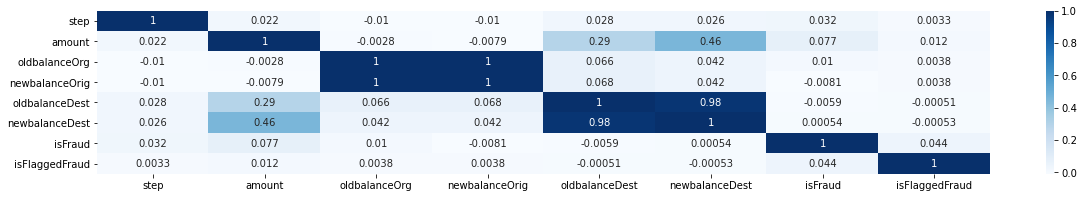

In [9]:
sns.heatmap(df.corr(),annot=True, cmap='Blues')
# We can Identify high colineality between:
# 1- OldbalanceDest and newbalanceDest
# 2- OldbalanceOrg and newbalanceOrig

### What is the distribution of the outcome? 

In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
print('% of Fraud:',len(df[df['isFraud']==1])/len(df[df['isFraud']==0])*100,'%')
# Seems that the data of this variable is very unbalanced

% of Fraud: 0.129248881917699 %


### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [12]:
# Your code here
df2=df.copy()

In [13]:
df2=pd.get_dummies(df2,columns=['type'],drop_first=True)
df2

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,1


In [14]:
df2.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

### Run a logisitc regression classifier and evaluate its accuracy.

In [20]:
X=df2.drop(columns='isFraud')
y=df2['isFraud']

In [21]:
# Your code here
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [26]:
lr=LogisticRegression(max_iter=1000)

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [28]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [29]:
lr.score(X_test,y_test)  # score of test data

0.9983128019589415

In [31]:
# Your code here
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

prediction = lr.predict(X_test)
print(confusion_matrix(y_test, prediction))
           
print(classification_report(y_test, prediction))

# The recall of '1' values is equal to 0.41 (very low score), we can see that the model is assinging most of the cases
# to the '0' values due to the imbalance of records between the two variables

[[1269705    1199]
 [    948     672]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.36      0.41      0.38      1620

    accuracy                           1.00   1272524
   macro avg       0.68      0.71      0.69   1272524
weighted avg       1.00      1.00      1.00   1272524



### Now pick a model of your choice and evaluate its accuracy.

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

balance_data=RandomUnderSampler()
X_bln,y_bln=balance_data.fit_resample(X,y)
X_train,X_test,y_train,y_test=train_test_split(X_bln,y_bln,test_size=0.3,random_state=42)
prediction=XGBClassifier().fit(X_train,y_train).predict(X_test)


C:\Users\joanu\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
print(confusion_matrix(y_test, prediction))
           
print(classification_report(y_test, prediction))


[[2457   22]
 [   7 2442]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2479
           1       0.99      1.00      0.99      2449

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



### Which model worked better and how do you know?

In [18]:
# Your response here
# XGBoost after doing an undersample in order to balance the data